# `Практикум по программированию на языке Python`

## `Задание 1.5. Классификация изображений`.

#### Фамилия, имя: 

Дата выдачи: <span style="color:red">__5 марта__</span>.

Мягкий дедлайн: <span style="color:red">__12 марта 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __3 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2024`

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set_theme(style="darkgrid")

plt.rcParams['figure.figsize'] = [16, 7]
plt.rc('font', size=14)          # controls default text sizes
plt.rc('figure', titlesize=15)  # fontsize of the figure title

random_seed = 0
torch.manual_seed(random_seed)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## `Задание 1. Загрузка данных (0.5 балла)`

В этой домашке работа с данными будем максимально облегчённой. Мы скачаем MNIST с помощью [стандартных средств](https://pytorch.org/vision/0.8/datasets.html#mnist) торча. Посмотреть список других доступных датасетов можно [здесь](https://pytorch.org/vision/0.8/datasets.html).

In [2]:
def load_mnist(train, transform=None):    
    if transform is None:
        transform = T.ToTensor()
    return torchvision.datasets.MNIST(
        root='./data',
        train=train,
        transform=transform,
        download=True
    )

Пиксели изображений принимают значения [0,1]. Скачайте датасет и посчитайте выборочное среднее и выборочное стандартное отклонение для значения пикселя. Т.е. должно получиться число `mean` для среднего, и число `std` для стандартного отклонения.

*Подсказка.* Подумайте, на какой части датасета нужно считать эти статистики (обучение или валидация), чтобы предотвратить утечку данных.

*Подсказка.* У торч датасета реализован метод `__getitem__`, т.е. его можно индексировать `dataset[i]`.

In [3]:
train_mnist = load_mnist(train=True)
val_mnist = load_mnist(train=False)

len(train_mnist), len(val_mnist)

(60000, 10000)

In [4]:
mean = 0

for elem, _ in train_mnist:
    mean += torch.sum(elem)

cnt = len(train_mnist) * torch.tensor(train_mnist[0][0].shape).prod()
mean /= cnt

std = 0
for elem, _ in train_mnist:
    std += torch.sum((elem - mean) ** 2)

std /= cnt
std = torch.sqrt(std)

mean = mean.item()
std = std.item()

mean, std

(0.13066048920154572, 0.308107852935791)

Полученные значения можно применить для нормализации изображений, когда будем подавать их в нейросеть.

In [5]:
norm_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std)
])

train_mnist = load_mnist(True, norm_transform)
val_mnist = load_mnist(False, norm_transform)

Во время обучения данные подаются в нейросеть батчами.

Обычно batch_size выбирается так, чтобы во время обучения получалась меньше дисперсия градиента (ну вы уже знакомы с sgd), также часто batch_size выбирается максимально возможным по ресурсам.

Для этой задачи нам хватит batch_size = 64 во время обучения.

*Ответьте на вопрос:* Почему в большинстве задач для валидации и тестирования можно выбирать batch_size больше? 

**Ответ:** поскольку при валидации и тестировании можно не хранить градиенты, значит освобождается больше месте для хранения объектов.

In [6]:
from torch.utils.data import DataLoader

batch_size_train = 64
batch_size_test = 1000

train_mnist_loader = DataLoader(
    dataset=train_mnist,
    batch_size=batch_size_train,
    shuffle=True,
    drop_last=True
)

val_mnist_loader = DataLoader(
    dataset=val_mnist,
    batch_size=batch_size_test,
    shuffle=False,
    drop_last=False
)

In [7]:
images, labels = next(iter(train_mnist_loader))
images.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

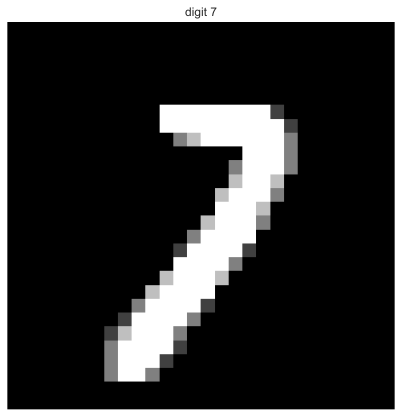

In [8]:
i = 3
plt.title(f'digit {labels[i]}')
plt.imshow(images[i, 0], cmap='gray')
plt.axis('off')
plt.show()

## `Задание 2. Цикл обучения (1.5 балла)`

Ниже предоставлен базовый вариант цикла обучения, представленный тремя функциями: `train_epoch`, `val_epoch`, `train_val`.

In [9]:
def train_epoch(
    network,
    train_loader,
    criterion,
    optimizer,
):
    """train `network` with `optimizer` for one epoch with data from `train_loader` to minimize `criterion`"""
    
    network.train()  # switch network submodules to train mode, e.g. it influences on batch-norm, dropout
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)   # send data to device
        optimizer.zero_grad()   # zero out grads, collected from previous batch
        logits = network(images)  # forward pass
        loss = criterion(logits, labels, reduction='mean')
        loss.backward()
        optimizer.step()

In [10]:
@torch.no_grad()
def val_epoch(
    network,
    val_loader,
    criterion,
):
    """calculate loss and accuracy on validation data"""
    val_loss = 0
    correct = 0

    network.eval()  # switch network submodules to test mode
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        logits = network(images)
        val_loss += criterion(logits, labels, reduction='sum').item()
        pred = torch.argmax(logits, dim=1)
        correct += torch.sum(pred == labels).item()

    val_loss /= len(val_loader.dataset)
    val_accur = correct / len(val_loader.dataset)

    print(
        f'Test set: Avg. loss: {val_loss:.4f}',
        f'Accuracy: {correct}/{len(val_loader.dataset)}',
        f'({100. * val_accur:.0f}%)',
    )

In [11]:
def train_val(
    network,
    n_epochs,
    criterion,
    optimizer,
    train_loader,
    val_loader,
):
    """full cycle of neural network training"""

    val_epoch(network, val_loader, criterion)
    for epoch in range(1, n_epochs + 1):
        train_epoch(network, train_loader, criterion, optimizer)
        val_epoch(network, val_loader, criterion)

Для проверки, что все работает, обучите бейзлайн -- однослойную [полносвязную](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) сеть на [кросс-энтропийный лосс](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html). 


*Заметьте*, что на вход этому лоссу нужно подавать сырой выход нейросети, а не результат применения софтмакса.

In [12]:
class LogReg(nn.Module):
    def __init__(self, in_features , out_features, device=device):
        super().__init__()

        self.linear = nn.Linear(in_features, out_features, device=device)

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = self.linear(x)
        return x

In [14]:
lr = 1e-3
n_epoch = 5
in_features = torch.tensor(train_mnist[0][0].shape).prod()

net = LogReg(in_features, 10)

optimizer = optim.Adam(net.parameters(), lr)

train_val(net, n_epoch, F.cross_entropy, optimizer, train_mnist_loader, val_mnist_loader)

Test set: Avg. loss: 2.4794 Accuracy: 823/10000 (8%)
Test set: Avg. loss: 0.3034 Accuracy: 9145/10000 (91%)
Test set: Avg. loss: 0.2746 Accuracy: 9233/10000 (92%)
Test set: Avg. loss: 0.2732 Accuracy: 9229/10000 (92%)
Test set: Avg. loss: 0.2847 Accuracy: 9185/10000 (92%)
Test set: Avg. loss: 0.2805 Accuracy: 9223/10000 (92%)


## `Задание 3. Логирование (3 балл)`

Скопируйте и перепишите функции `train_epoch`, `val_epoch`, `train_val` таким образом, чтобы
- во время обучения раз в `logging_interval` шагов оптимизации выводились лосс и аккураси на одном батче (пример ниже, но не обязательно делать идентично)
- происходило сохранение весов лучшей (по аккураси на валидации) модели и состояния оптимизатора ([в помощь](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-state-dict-recommended))
- в конце обучения выводился и сохранялся график-саммари (пример ниже, но не обязательно делать идентично)

*Ответьте на вопрос:* Что хранится в состоянии оптимизатора? Зачем нужно его сохранять? Приведите хотя бы один пример оптимизатора, для которого есть смысл сохранять состояние.

**Ответ:** состояние оптимизатора надо сохранять, если мы хотим продолжить обучение, т.к., например, Adam сохраняет внутри себя некоторые статистики в процессе обучения.

In [13]:
from time import time
import os


def train_epoch(
    network,
    train_loader,
    criterion,
    optimizer,
    epoch,
    logging_interval
):
    """train `network` with `optimizer` for one epoch with data from `train_loader` to minimize `criterion`"""
    train_loss_list = []
    approx_epoch_list = []

    step = 0
    objects_cnt = 0
    network.train()  # switch network submodules to train mode, e.g. it influences on batch-norm, dropout
    print()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)   # send data to device
        optimizer.zero_grad()   # zero out grads, collected from previous batch
        logits = network(images)  # forward pass
        loss = criterion(logits, labels, reduction='mean')
        loss.backward()

        
        if step == 0:
            objects_part = objects_cnt / len(train_loader.dataset)
            print(
                f'Train Epoch: {epoch}',
                f'[{objects_cnt}/{len(train_loader.dataset)}',
                f'({100. * objects_part:.0f}%)]', end="\t"
            )
            print(f"Loss: {loss.item():.6f}")
            train_loss_list.append(loss.item())
            approx_epoch_list.append(epoch - 1 + objects_part)
            

        step = (step + 1) % logging_interval
        objects_cnt += labels.shape[0]

        optimizer.step()
    print()

    return approx_epoch_list, train_loss_list


@torch.no_grad()
def val_epoch(
    network,
    val_loader,
    criterion,
):
    """calculate loss and accuracy on validation data"""
    val_loss = 0
    correct = 0

    network.eval()  # switch network submodules to test mode
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        logits = network(images)
        val_loss += criterion(logits, labels, reduction='sum').item()
        pred = torch.argmax(logits, dim=1)
        correct += torch.sum(pred == labels).item()

    val_loss /= len(val_loader.dataset)
    val_accur = correct / len(val_loader.dataset)

    print(
        f'Validation set: Avg. loss: {val_loss:.4f},',
        f'Accuracy: {correct}/{len(val_loader.dataset)}',
        f'({100. * val_accur:.0f}%)',
    )

    return val_loss, val_accur


def train_val(
    network,
    n_epochs,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    model_name,
    checkpoint_dir = "./checkpoints",
    logging_interval=300
):
    """full cycle of neural network training"""
    
    t = time()
    accur_list = []
    time_list = []
    train_approx_epoch_list = []
    train_loss_list = []
    test_loss_list = []
    best_accur = 0

    val_loss, val_accur = val_epoch(network, val_loader, criterion)
    accur_list.append(val_accur)
    time_list.append(time() - t)
    test_loss_list.append(val_loss)

    if val_accur > best_accur:
            best_accur = val_accur
            torch.save({
                    'epoch': 0,
                    'model_state_dict': network.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': val_loss,
                    'val_accuracy': val_accur
                }, os.path.join(checkpoint_dir, model_name + ".pth"))

    for epoch in range(1, n_epochs + 1):    
        approx_epoch_list_, train_loss_list_ = train_epoch(
            network, train_loader, criterion, optimizer, epoch, logging_interval
        )
        train_approx_epoch_list += approx_epoch_list_
        train_loss_list += train_loss_list_

        val_loss, val_accur = val_epoch(network, val_loader, criterion)
        accur_list.append(val_accur)
        time_list.append(time() - t)
        test_loss_list.append(val_loss)
        
        if val_accur > best_accur:
            best_accur = val_accur
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': network.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': val_loss,
                    'val_accuracy': val_accur
                }, os.path.join(checkpoint_dir, model_name + ".pth"))
            
    total_time = time() - t

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_approx_epoch_list, train_loss_list, label="Train Loss")
    plt.plot(test_loss_list, label="Test Loss", marker="o")
    plt.xlabel("epochs completed")
    plt.ylabel("loss")
    plt.legend()
    plt.xticks(torch.arange(n_epochs + 1))

    plt.subplot(1, 2, 2)
    plt.plot(time_list, accur_list, marker="o")
    plt.xlabel("time, s")
    plt.ylabel("accuracy")

    plt.suptitle(f"{model_name} (best accuracy {best_accur * 100:.2f}%, total time {total_time:.1f} s)")
    plt.show()
    

Validation set: Avg. loss: 2.4017, Accuracy: 1109/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.379192
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.380233
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.282122
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.451038

Validation set: Avg. loss: 0.2958, Accuracy: 9146/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.339676
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.238842
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.217975
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.491929

Validation set: Avg. loss: 0.2792, Accuracy: 9218/10000 (92%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.200399
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.192199
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.303656
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.240862

Validation set: Avg. loss: 0.2728, Accuracy: 9236/10000 (92%)


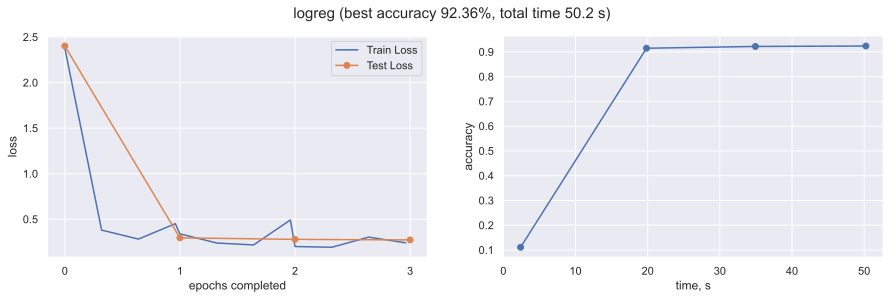

In [73]:
lr = 1e-3
n_epoch = 3
in_features = torch.tensor(train_mnist[0][0].shape).prod()

net = LogReg(in_features, 10)
optimizer = optim.Adam(net.parameters(), lr)

train_val(net, n_epoch, F.cross_entropy, optimizer, train_mnist_loader, val_mnist_loader, "logreg")

Загрузите лучшие веса модели и подсчитайте аккураси на валидации, чтобы подтвердить что веса сохранились корректно.

In [74]:
saved = torch.load("./checkpoints/logreg.pth")
net.load_state_dict(saved["model_state_dict"])
_, __ = val_epoch(net, val_mnist_loader, F.cross_entropy)

Validation set: Avg. loss: 0.2728, Accuracy: 9236/10000 (92%)


Загрузите сохранённое состояние оптимизатора и сделайте две эпохи обучения, чтобы подтвердить, что состояния оптимизатора были сохранены корректно.

Validation set: Avg. loss: 0.2728, Accuracy: 9236/10000 (92%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.209820
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.552405
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.401448
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.154379

Validation set: Avg. loss: 0.2773, Accuracy: 9246/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.124769
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.547187
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.513351
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.161829

Validation set: Avg. loss: 0.2812, Accuracy: 9201/10000 (92%)


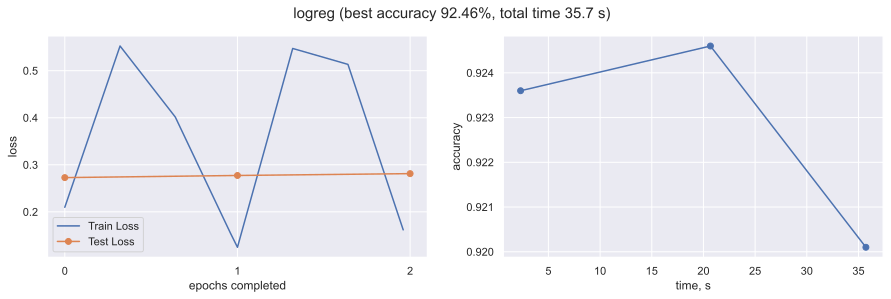

In [75]:
optimizer.load_state_dict(saved["optimizer_state_dict"])
train_val(net, 2, F.cross_entropy, optimizer, train_mnist_loader, val_mnist_loader, "logreg")

## `Задание 4. Логирование с помощью tensorboard (1 балл)`

На самом деле это дурной тон логировать обучение нейросети так, как это сделали вы выше. Дело в том, что весь функционал уже реализован в [`tensorboard`](https://pytorch.org/docs/stable/tensorboard.html), а вы написали велосипед.

In [2]:
from torch.utils.tensorboard import SummaryWriter

Если у вас есть доступ к терминалу и браузеру, то удобнее всего ввести команду
```bash
tensorboard --logdir .
```
и открыть UI в выделенном локалхосте. 

Если вы работаете в гугл колабе, то можете запустить UI как виджет в Jupyter:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir .

Как только вы начнете логировать в объект типа `SummaryWriter`, в UI начнут строиться кривые обучения.

Скопируйте и перепишите функции обучения таким образом, чтобы логирование происходило в `tensorboard`.

*Замечание.* Вам пригодится метод `add_scalar`, чтобы сохранять лосс и аккураси, и метод `add_hparams`, чтобы сохранить важные гиперпараметры (например, кодовое имя архитектуры сети) и финальное достигнутое качество.

In [40]:
from time import time
import os
from tqdm import tqdm


def train_epoch(
    network,
    train_loader,
    criterion,
    optimizer,
    logging_interval,
    writer,
    global_step
):
    """train `network` with `optimizer` for one epoch with data from `train_loader` to minimize `criterion`"""

    step = 0
    network.train()  # switch network submodules to train mode, e.g. it influences on batch-norm, dropout
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)   # send data to device
        optimizer.zero_grad()   # zero out grads, collected from previous batch
        logits = network(images)  # forward pass
        loss = criterion(logits, labels, reduction='mean')
        loss.backward()
        
        if step == 0:
            writer.add_scalar("Loss/train", loss.item(), global_step)
            global_step += 1

        step = (step + 1) % logging_interval
        optimizer.step()

    return global_step


@torch.no_grad()
def val_epoch(
    network,
    val_loader,
    criterion,
    writer=None,
    global_step=None
):
    """calculate loss and accuracy on validation data"""
    val_loss = 0
    correct = 0

    network.eval()  # switch network submodules to test mode
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        logits = network(images)
        val_loss += criterion(logits, labels, reduction='sum').item()
        pred = torch.argmax(logits, dim=1)
        correct += torch.sum(pred == labels).item()

    val_loss /= len(val_loader.dataset)
    val_accur = correct / len(val_loader.dataset)

    if writer is not None:
        writer.add_scalar("Loss/test", val_loss, global_step)
        writer.add_scalar("Accuracy/test", val_accur, global_step)
        writer.add_scalar("Correct/test", correct, global_step)

    return val_loss, val_accur


def train_val(
    network,
    n_epochs,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    model_name=None,
    checkpoint_dir = "./checkpoints",
    logging_interval=300,
    scheduler=None,
    scheduler_step_arg=None,
    device=device
):
    """full cycle of neural network training"""

    if model_name is None:
        model_name = network.__class__.__name__

    network = network.to(device)

    writer = SummaryWriter(log_dir=os.path.join("runs", model_name))

    t = time()
    best_accur = 0
    global_step = 0

    val_loss, val_accur = val_epoch(network, val_loader, criterion, writer, global_step)

    if val_accur > best_accur:
            best_accur = val_accur
            torch.save({
                    'epoch': 0,
                    'model_state_dict': network.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': val_loss,
                    'val_accuracy': val_accur
                }, os.path.join(checkpoint_dir, model_name + ".pth"))

    for epoch in tqdm(range(1, n_epochs + 1)):    
        global_step = train_epoch(
            network, train_loader, criterion, optimizer, logging_interval, writer, global_step
        )

        val_loss, val_accur = val_epoch(network, val_loader, criterion, writer, global_step)

        if val_accur > best_accur:
            best_accur = val_accur
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': network.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': val_loss,
                    'val_accuracy': val_accur
                }, os.path.join(checkpoint_dir, model_name + ".pth"))
            
        if scheduler is not None:
            if scheduler_step_arg is None:
                scheduler.step()
            elif scheduler_step_arg == "val_loss":
                scheduler.step(val_loss)
            elif scheduler_step_arg == "val_accuracy":
                scheduler.step(val_accur)
            else:
                raise NotImplementedError("incorrect scheduler_step_arg")
            
            writer.add_scalar("lr", torch.tensor(scheduler.get_last_lr()), global_step)
            
    total_time = time() - t
    
    hparam_dict = {
        "model_name": model_name,
    }
    metric_dict = {
        "best accuracy": best_accur * 100,
        "total time": total_time
    }
    writer.add_hparams(hparam_dict, metric_dict)
    writer.close()
    

In [56]:
lr = 1e-3
n_epoch = 3
in_features = torch.tensor(train_mnist[0][0].shape).prod()

net = LogReg(in_features, 10)
optimizer = optim.Adam(net.parameters(), lr)

train_val(net, n_epoch, F.cross_entropy, optimizer, train_mnist_loader, val_mnist_loader, "logreg_tb")

100%|██████████| 3/3 [00:49<00:00, 16.64s/it]


## `Задание 5. Побейте бейзлайн (2+2 балла)`

На датасете [`CIFAR-10`](https://pytorch.org/vision/0.8/datasets.html#torchvision.datasets.CIFAR10) обучите модель, которая выдает аккураси `>=0.7` (2 балла) и аккураси `>=0.8` (ещё 2 балла).
- Можете использовать любые модули `pytorch`, любые оптимизаторы и шедулеры, можете использовать аугментации ([например](https://pytorch.org/vision/stable/transforms.html))
- Для отслеживания экспериментов используйте логирование с `tensorboard`, не забывайте давать осмысленные имена эспериментам и логировать нужные гиперпараметры, сохранять веса сети и состояние оптимизатора.

In [4]:
def load_cifar10(train, transform=None):    
    if transform is None:
        transform = T.ToTensor()
    return torchvision.datasets.CIFAR10(
        root='./data',
        train=train,
        transform=transform,
        download=True
    )

train_cifar10 = load_cifar10(train=True)
val_cifar10 = load_cifar10(train=False)

len(train_cifar10), len(val_cifar10)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [5]:
train_cifar10[100][0].shape

torch.Size([3, 32, 32])

In [6]:
mean = 0

for elem, _ in train_cifar10:
    mean += torch.sum(elem)

cnt = len(train_cifar10) * torch.tensor(train_cifar10[0][0].shape).prod()
mean /= cnt

std = 0
for elem, _ in train_cifar10:
    std += torch.sum((elem - mean) ** 2)

std /= cnt
std = torch.sqrt(std)

mean = mean.item()
std = std.item()

mean, std

(0.47336167097091675, 0.25156864523887634)

In [7]:
# аугментация

norm_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std)
])

transform_train = T.Compose([
                            T.ToTensor(), 
                            T.Normalize(mean, std),
                            T.RandomCrop((32, 32)),
                            T.RandomHorizontalFlip(p=0.5),
                            T.RandomGrayscale(p=0.1)])

transform_test = T.Compose([T.ToTensor(), T.Normalize(mean, std), T.CenterCrop((32, 32))])

train_cifar10 = load_cifar10(True, transform_train)
val_cifar10 = load_cifar10(False, transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
import numpy as np
import random

def set_global_seed(seed: int) -> None:
    """
    Set global seed for reproducibility.
    """
    

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
#     torch.use_deterministic_algorithms(True) # если нужно гарантировать 1000% воспроизводимость

    # Для Dataloader
    g = torch.Generator()
    g.manual_seed(seed)
    
    return g

# Для каждого woerker в Daaloader
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


In [9]:
from torch.utils.data import DataLoader

batch_size_train = 64
batch_size_test = 1000

g = set_global_seed(42)

train_cifar10_loader = DataLoader(
    dataset=train_cifar10,
    batch_size=batch_size_train,
    shuffle=True,
    drop_last=True,
    generator=g
)

val_cifar10_loader = DataLoader(
    dataset=val_cifar10,
    batch_size=batch_size_test,
    shuffle=False,
    drop_last=False
)

In [10]:
vis_dataloader = DataLoader(train_cifar10, batch_size=16, shuffle=True, num_workers=0)
batch = next(iter(vis_dataloader))

batch[0].shape, batch[1]

(torch.Size([16, 3, 32, 32]),
 tensor([6, 0, 4, 1, 2, 7, 9, 4, 7, 8, 4, 5, 6, 0, 4, 2]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


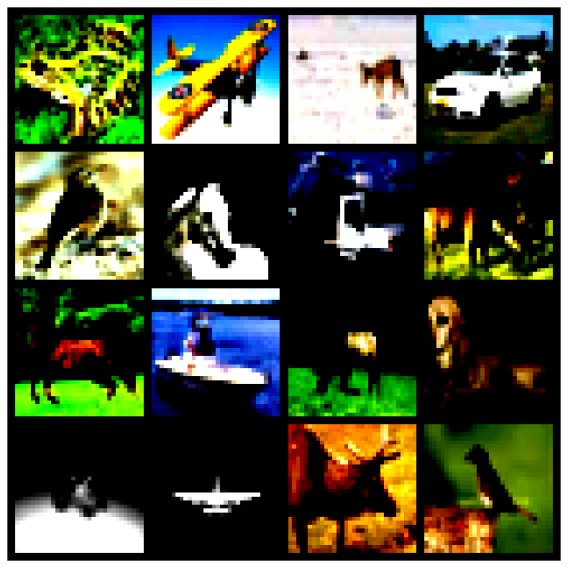

In [11]:
img_grid = torchvision.utils.make_grid(batch[0], nrow=4)

plt.figure(figsize=(10, 10))
plt.imshow(img_grid.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

### LogReg

In [114]:
# logreg

lr = 1e-4
n_epoch = 10

net = LogReg(32 * 32 * 3,  10)
optimizer = optim.Adam(net.parameters(), lr)

train_val(net, n_epoch, F.cross_entropy, optimizer, train_cifar10_loader, val_cifar10_loader, "LogReg_cifar")

100%|██████████| 10/10 [04:38<00:00, 27.86s/it]


In [23]:
def print_accuracy(model, model_name=None):
    if model_name is None:
        model_name = model.__class__.__name__

    saved = torch.load(f"./checkpoints/{model_name}.pth")
    model.load_state_dict(saved["model_state_dict"])
    _, acc = val_epoch(model, val_cifar10_loader, F.cross_entropy)
    print(f"{model_name} accuracy: {acc:.4f}")

In [116]:
print_accuracy(net, "LogReg_cifar")

LogReg_cifar accuracy: 0.4167


### LeNet

In [117]:
class LeNet(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5, 5)),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5)),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            torch.nn.ReLU(),
        )
        
        self.dense = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(16 * 5 * 5, 120),
            torch.nn.ReLU(),
            torch.nn.Linear(120, 84),
            torch.nn.ReLU(),
            torch.nn.Linear(84, n_classes),
        )

    def forward(self, x):
        return self.dense(self.features(x))

In [118]:
# LeNet with Adam

lr = 1e-4
n_epoch = 30

net = LeNet(10)
optimizer = optim.Adam(net.parameters(), lr)

train_val(net, n_epoch, F.cross_entropy, optimizer, train_cifar10_loader, val_cifar10_loader, "LeNet")
print_accuracy(net, "LeNet")

100%|██████████| 30/30 [13:35<00:00, 27.18s/it]


LeNet accuracy: 0.6169


### ResNet18

In [119]:
from torchvision.models import resnet18

class ResNet18Wrapper(nn.Module):
    def __init__(self, resnet_model):
        super().__init__()
        
        self.resnet_block = resnet_model
        
    def forward(self, x):        
        x = torch.nn.functional.interpolate(x, scale_factor=1)
        x = self.resnet_block(x)

        return x

In [159]:
# resnet18 with Adam

lr = 1e-4
n_epoch = 30

g = set_global_seed(42)

train_cifar10_loader = DataLoader(
    train_cifar10, batch_size=256, shuffle=True,
    worker_init_fn=seed_worker, generator=g, drop_last=True
)

val_cifar10_loader = DataLoader(
    val_cifar10, batch_size=4096, shuffle=False
)

resnet_model = resnet18()
resnet_model.fc = torch.nn.Linear(512, 10) 
net = ResNet18Wrapper(resnet_model)

optimizer = optim.Adam(net.parameters(), lr)

train_val(net, n_epoch, F.cross_entropy, optimizer, train_cifar10_loader, val_cifar10_loader, "resnet18")
print_accuracy(net, "resnet18")

100%|██████████| 30/30 [14:50<00:00, 29.70s/it]


resnet18 accuracy: 0.6557


In [136]:
# resnet18 with SGD

lr = 1e-2
n_epoch = 30

g = set_global_seed(42)

train_cifar10_loader = DataLoader(
    train_cifar10, batch_size=256, shuffle=True,
    worker_init_fn=seed_worker, generator=g, drop_last=True
)

val_cifar10_loader = DataLoader(
    val_cifar10, batch_size=4096, shuffle=False
)

resnet_model = resnet18()
resnet_model.fc = torch.nn.Linear(512, 10) 
net = ResNet18Wrapper(resnet_model)

optimizer = optim.SGD(net.parameters(), lr)

train_val(net, n_epoch, F.cross_entropy, optimizer, train_cifar10_loader, val_cifar10_loader, "resnet_SGD")
print_accuracy(net, "resnet_SGD")

100%|██████████| 30/30 [15:39<00:00, 31.32s/it]


resnet_SGD accuracy: 0.6542


### Cifar10CnnModel

Архитектура модели позаимствована [отсюда](https://www.kaggle.com/code/shadabhussain/cifar-10-cnn-using-pytorch/notebook).

In [233]:
class Cifar10CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [138]:
# Cifar10CnnModel with Adam

lr = 1e-4
n_epoch = 30

g = set_global_seed(42)

train_cifar10_loader = DataLoader(
    train_cifar10, batch_size=256, shuffle=True,
    worker_init_fn=seed_worker, generator=g, drop_last=True
)

val_cifar10_loader = DataLoader(
    val_cifar10, batch_size=4096, shuffle=False
)

net = Cifar10CnnModel()

optimizer = optim.Adam(net.parameters(), lr)

train_val(net, n_epoch, F.cross_entropy, optimizer, train_cifar10_loader, val_cifar10_loader, "Cifar10CnnModel")
print_accuracy(net, "Cifar10CnnModel")

100%|██████████| 30/30 [17:06<00:00, 34.22s/it]


Cifar10CnnModel accuracy: 0.7724


In [139]:
# Cifar10CnnModel with SGDM

lr = 1e-2
momentum = 0.9
n_epoch = 30

g = set_global_seed(42)

train_cifar10_loader = DataLoader(
    train_cifar10, batch_size=256, shuffle=True,
    worker_init_fn=seed_worker, generator=g, drop_last=True
)

val_cifar10_loader = DataLoader(
    val_cifar10, batch_size=4096, shuffle=False
)

net = Cifar10CnnModel()

optimizer = optim.SGD(net.parameters(), lr, momentum)

train_val(net, n_epoch, F.cross_entropy, optimizer, train_cifar10_loader, val_cifar10_loader, "Cifar10CnnModel_SGDM")
print_accuracy(net, "Cifar10CnnModel_SGDM")

100%|██████████| 30/30 [16:57<00:00, 33.91s/it]


Cifar10CnnModel_SGDM accuracy: 0.7846


In [160]:
# Cifar10CnnModel with SGDM + scheduler

lr = 1e-2
momentum = 0.9
n_epoch = 30

g = set_global_seed(42)

train_cifar10_loader = DataLoader(
    train_cifar10, batch_size=256, shuffle=True,
    worker_init_fn=seed_worker, generator=g, drop_last=True
)

val_cifar10_loader = DataLoader(
    val_cifar10, batch_size=4096, shuffle=False
)

net = Cifar10CnnModel()

optimizer = optim.SGD(net.parameters(), lr, momentum)
scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
#scheduler2 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

train_val(net, n_epoch, F.cross_entropy, optimizer, train_cifar10_loader, val_cifar10_loader,
          "Cifar10CnnModel_SGDM_sched", scheduler=scheduler1)

print_accuracy(net, "Cifar10CnnModel_SGDM_sched")

100%|██████████| 30/30 [15:08<00:00, 30.29s/it]


Cifar10CnnModel_SGDM_sched accuracy: 0.7243


### Cifar10CnnModel v2

Усовершенствуем архитектуру сети Cifar10CnnModel следующим образом:
1. добавим слои BatchNorm;
2. добавим [global average pool](https://education.yandex.ru/handbook/ml/article/svyortochnye-nejroseti#global-average-pool);
3. полносвязные линейные слои будем инициализировать с помощью [Kaiming Initialization](https://arxiv.org/pdf/1502.01852.pdf).

In [26]:
class Cifar10CnnModel_v2(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            # Global average pool
            nn.AdaptiveAvgPool2d((1,1)), # output: 256 x 1 x 1

            nn.Flatten(), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        
        # kaiming init
        self.network.apply(self._init_weights)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")

    def forward(self, xb):
        return self.network(xb)

In [232]:
# Cifar10CnnModel_v2 with SGDM

lr = 1e-2
momentum = 0.9
n_epoch = 30

g = set_global_seed(42)

train_cifar10_loader = DataLoader(
    train_cifar10, batch_size=256, shuffle=True,
    worker_init_fn=seed_worker, generator=g, drop_last=True
)

val_cifar10_loader = DataLoader(
    val_cifar10, batch_size=4096, shuffle=False
)

net = Cifar10CnnModel_v2()

optimizer = optim.SGD(net.parameters(), lr, momentum)

train_val(net, n_epoch, F.cross_entropy, optimizer, train_cifar10_loader, val_cifar10_loader, "Cifar10CnnModel_v2_SGDM")
print_accuracy(net, "Cifar10CnnModel_v2_SGDM")

100%|██████████| 30/30 [18:53<00:00, 37.80s/it]


Cifar10CnnModel_v2_SGDM accuracy: 0.8641


In [235]:
# Cifar10CnnModel_v2 with Adam

lr = 1e-2
n_epoch = 30

g = set_global_seed(42)

train_cifar10_loader = DataLoader(
    train_cifar10, batch_size=256, shuffle=True,
    worker_init_fn=seed_worker, generator=g, drop_last=True
)

val_cifar10_loader = DataLoader(
    val_cifar10, batch_size=4096, shuffle=False
)

net = Cifar10CnnModel_v2()

optimizer = optim.Adam(net.parameters(), lr)

train_val(net, n_epoch, F.cross_entropy, optimizer, train_cifar10_loader, val_cifar10_loader, "Cifar10CnnModel_v2_Adam")
print_accuracy(net, "Cifar10CnnModel_v2_Adam")

100%|██████████| 30/30 [16:51<00:00, 33.72s/it]


Cifar10CnnModel_v2_Adam accuracy: 0.8647


**Итого:** получена accuracy = `0.8647`.

## `Бонус. Побейте бейзлайн (3 балла)`

На датасете `CIFAR-10` обучите модель, которая выдает аккураси `>=0.9`.

### ResNet50

In [236]:
from torchvision.models import resnet50

In [244]:
# resnet50 with Adam

lr = 1e-2
n_epoch = 30

g = set_global_seed(42)

train_cifar10_loader = DataLoader(
    train_cifar10, batch_size=256, shuffle=True,
    worker_init_fn=seed_worker, generator=g, drop_last=True
)

val_cifar10_loader = DataLoader(
    val_cifar10, batch_size=4096, shuffle=False
)

resnet_model = resnet50()
resnet_model.fc = torch.nn.Linear(2048, 10) 
net = ResNet18Wrapper(resnet_model)

optimizer = optim.Adam(net.parameters(), lr)

train_val(net, n_epoch, F.cross_entropy, optimizer, train_cifar10_loader, val_cifar10_loader, "ResNet50_Adam")
print_accuracy(net, "ResNet50_Adam")

100%|██████████| 30/30 [18:14<00:00, 36.49s/it]


ResNet50_Adam accuracy: 0.7806


### ResNet152

In [245]:
from torchvision.models import resnet152

In [248]:
# resnet152 with Adam

lr = 1e-4
n_epoch = 30

g = set_global_seed(42)

train_cifar10_loader = DataLoader(
    train_cifar10, batch_size=256, shuffle=True,
    worker_init_fn=seed_worker, generator=g, drop_last=True
)

val_cifar10_loader = DataLoader(
    val_cifar10, batch_size=4096, shuffle=False
)

resnet_model = resnet152()
resnet_model.fc = torch.nn.Linear(2048, 10) 
net = ResNet18Wrapper(resnet_model)

optimizer = optim.Adam(net.parameters(), lr)

train_val(net, n_epoch, F.cross_entropy, optimizer, train_cifar10_loader, val_cifar10_loader, "ResNet152_Adam")
print_accuracy(net, "ResNet152_Adam")

100%|██████████| 30/30 [2:52:08<00:00, 344.30s/it]  


ResNet152_Adam accuracy: 0.5235


### Cifar10CnnModel_v3

Добавим Dropout-слои.

In [27]:
class Cifar10CnnModel_v3(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            # Global average pool
            nn.AdaptiveAvgPool2d((1,1)), # output: 256 x 1 x 1

            nn.Flatten(), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        
        # kaiming init
        self.network.apply(self._init_weights)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")

    def forward(self, xb):
        return self.network(xb)

In [28]:
# Cifar10CnnModel_v3 with SGDM

lr = 1e-2
momentum = 0.9
n_epoch = 30

g = set_global_seed(42)

train_cifar10_loader = DataLoader(
    train_cifar10, batch_size=256, shuffle=True,
    worker_init_fn=seed_worker, generator=g, drop_last=True
)

val_cifar10_loader = DataLoader(
    val_cifar10, batch_size=4096, shuffle=False
)

net = Cifar10CnnModel_v3()

optimizer = optim.SGD(net.parameters(), lr, momentum)

train_val(net, n_epoch, F.cross_entropy, optimizer, train_cifar10_loader, val_cifar10_loader, "Cifar10CnnModel_v3_SGDM")
print_accuracy(net, "Cifar10CnnModel_v3_SGDM")

100%|██████████| 30/30 [13:18<00:00, 26.61s/it]


Cifar10CnnModel_v3_SGDM accuracy: 0.8799


In [29]:
# Cifar10CnnModel_v3 with Adam

lr = 1e-2
n_epoch = 30

g = set_global_seed(42)

train_cifar10_loader = DataLoader(
    train_cifar10, batch_size=256, shuffle=True,
    worker_init_fn=seed_worker, generator=g, drop_last=True
)

val_cifar10_loader = DataLoader(
    val_cifar10, batch_size=4096, shuffle=False
)

net = Cifar10CnnModel_v3()

optimizer = optim.Adam(net.parameters(), lr)

train_val(net, n_epoch, F.cross_entropy, optimizer, train_cifar10_loader, val_cifar10_loader, "Cifar10CnnModel_v3_Adam")
print_accuracy(net, "Cifar10CnnModel_v3_Adam")

100%|██████████| 30/30 [13:13<00:00, 26.44s/it]


Cifar10CnnModel_v3_Adam accuracy: 0.8754


In [42]:
# Cifar10CnnModel_v3 with SGDM + lr_scheduler.ExponentialLR

lr = 1e-2
momentum = 0.9
n_epoch = 90

g = set_global_seed(42)

train_cifar10_loader = DataLoader(
    train_cifar10, batch_size=256, shuffle=True,
    worker_init_fn=seed_worker, generator=g, drop_last=True
)

val_cifar10_loader = DataLoader(
    val_cifar10, batch_size=4096, shuffle=False
)

net = Cifar10CnnModel_v3()

optimizer = optim.SGD(net.parameters(), lr, momentum)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.93)

train_val(net, n_epoch, F.cross_entropy, optimizer, train_cifar10_loader, val_cifar10_loader,
          "Cifar10CnnModel_v3_SGDM_scheduler", scheduler=scheduler)
print_accuracy(net, "Cifar10CnnModel_v3_SGDM_scheduler")

100%|██████████| 90/90 [34:46<00:00, 23.19s/it]


Cifar10CnnModel_v3_SGDM_scheduler accuracy: 0.8752


In [43]:
scheduler.get_last_lr()

[1.4570195190263159e-05]

In [44]:
# Cifar10CnnModel_v3 with SGDM + lr_scheduler.StepLR

lr = 0.05
momentum = 0.9
n_epoch = 150

g = set_global_seed(42)

train_cifar10_loader = DataLoader(
    train_cifar10, batch_size=256, shuffle=True,
    worker_init_fn=seed_worker, generator=g, drop_last=True
)

val_cifar10_loader = DataLoader(
    val_cifar10, batch_size=4096, shuffle=False
)

net = Cifar10CnnModel_v3()

optimizer = optim.SGD(net.parameters(), lr, momentum)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=45, gamma=0.1)

train_val(net, n_epoch, F.cross_entropy, optimizer, train_cifar10_loader, val_cifar10_loader,
          "Cifar10CnnModel_v3_SGDM_scheduler_2", scheduler=scheduler)
print_accuracy(net, "Cifar10CnnModel_v3_SGDM_scheduler_2")

100%|██████████| 150/150 [1:14:52<00:00, 29.95s/it]


Cifar10CnnModel_v3_SGDM_scheduler_2 accuracy: 0.9006


In [45]:
saved_best = torch.load(f"./checkpoints/Cifar10CnnModel_v3_SGDM_scheduler_2.pth")
epoch_best = saved_best["epoch"]
accuracy_best = saved_best["val_accuracy"]
print(f"Лучшая accuracy ({accuracy_best :.4f}) достигнута на эпохе {epoch_best}.")

Лучшая accuracy (0.9006) достигнута на эпохе 70.


**Итого:** получена accuracy = `0.9006`.

### CPU vs GPU

In [46]:
print(device)
device = torch.device('cpu')
print(device)

cuda:0
cpu


In [ ]:
# Cifar10CnnModel_v3 with SGDM + lr_scheduler.StepLR

lr = 0.05
momentum = 0.9
n_epoch = 150

g = set_global_seed(42)

train_cifar10_loader = DataLoader(
    train_cifar10, batch_size=256, shuffle=True,
    worker_init_fn=seed_worker, generator=g, drop_last=True
)

val_cifar10_loader = DataLoader(
    val_cifar10, batch_size=4096, shuffle=False
)

net = Cifar10CnnModel_v3()

optimizer = optim.SGD(net.parameters(), lr, momentum)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=45, gamma=0.1)

train_val(net, n_epoch, F.cross_entropy, optimizer, train_cifar10_loader, val_cifar10_loader,
          "Cifar10CnnModel_v3_SGDM_scheduler_2_CPU", scheduler=scheduler, device=device)
print_accuracy(net, "Cifar10CnnModel_v3_SGDM_scheduler_2_CPU")

In [50]:
463 / 30

15.433333333333334

GPU быстрее CPU в 15 раз.

In [54]:
22.24 / 29.95

0.7425709515859766

GPU Tesla T4 из колаба быстрее моей 3060 laptop на 26%